### Packages loading

In [3]:
import sys
sys.path.insert(0, '..')
import numpy as np
import random
import qiskit
import qtm.evolution
import qtm.state
import qtm.qcompilation
import qtm.ansatz
import qtm.constant
from qtm.evolution import environment, mutate, selection, crossover, utils
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2


## 1. Quantum architecture search for quantum state preparation problem

Now, we defind the problem which is need to solve

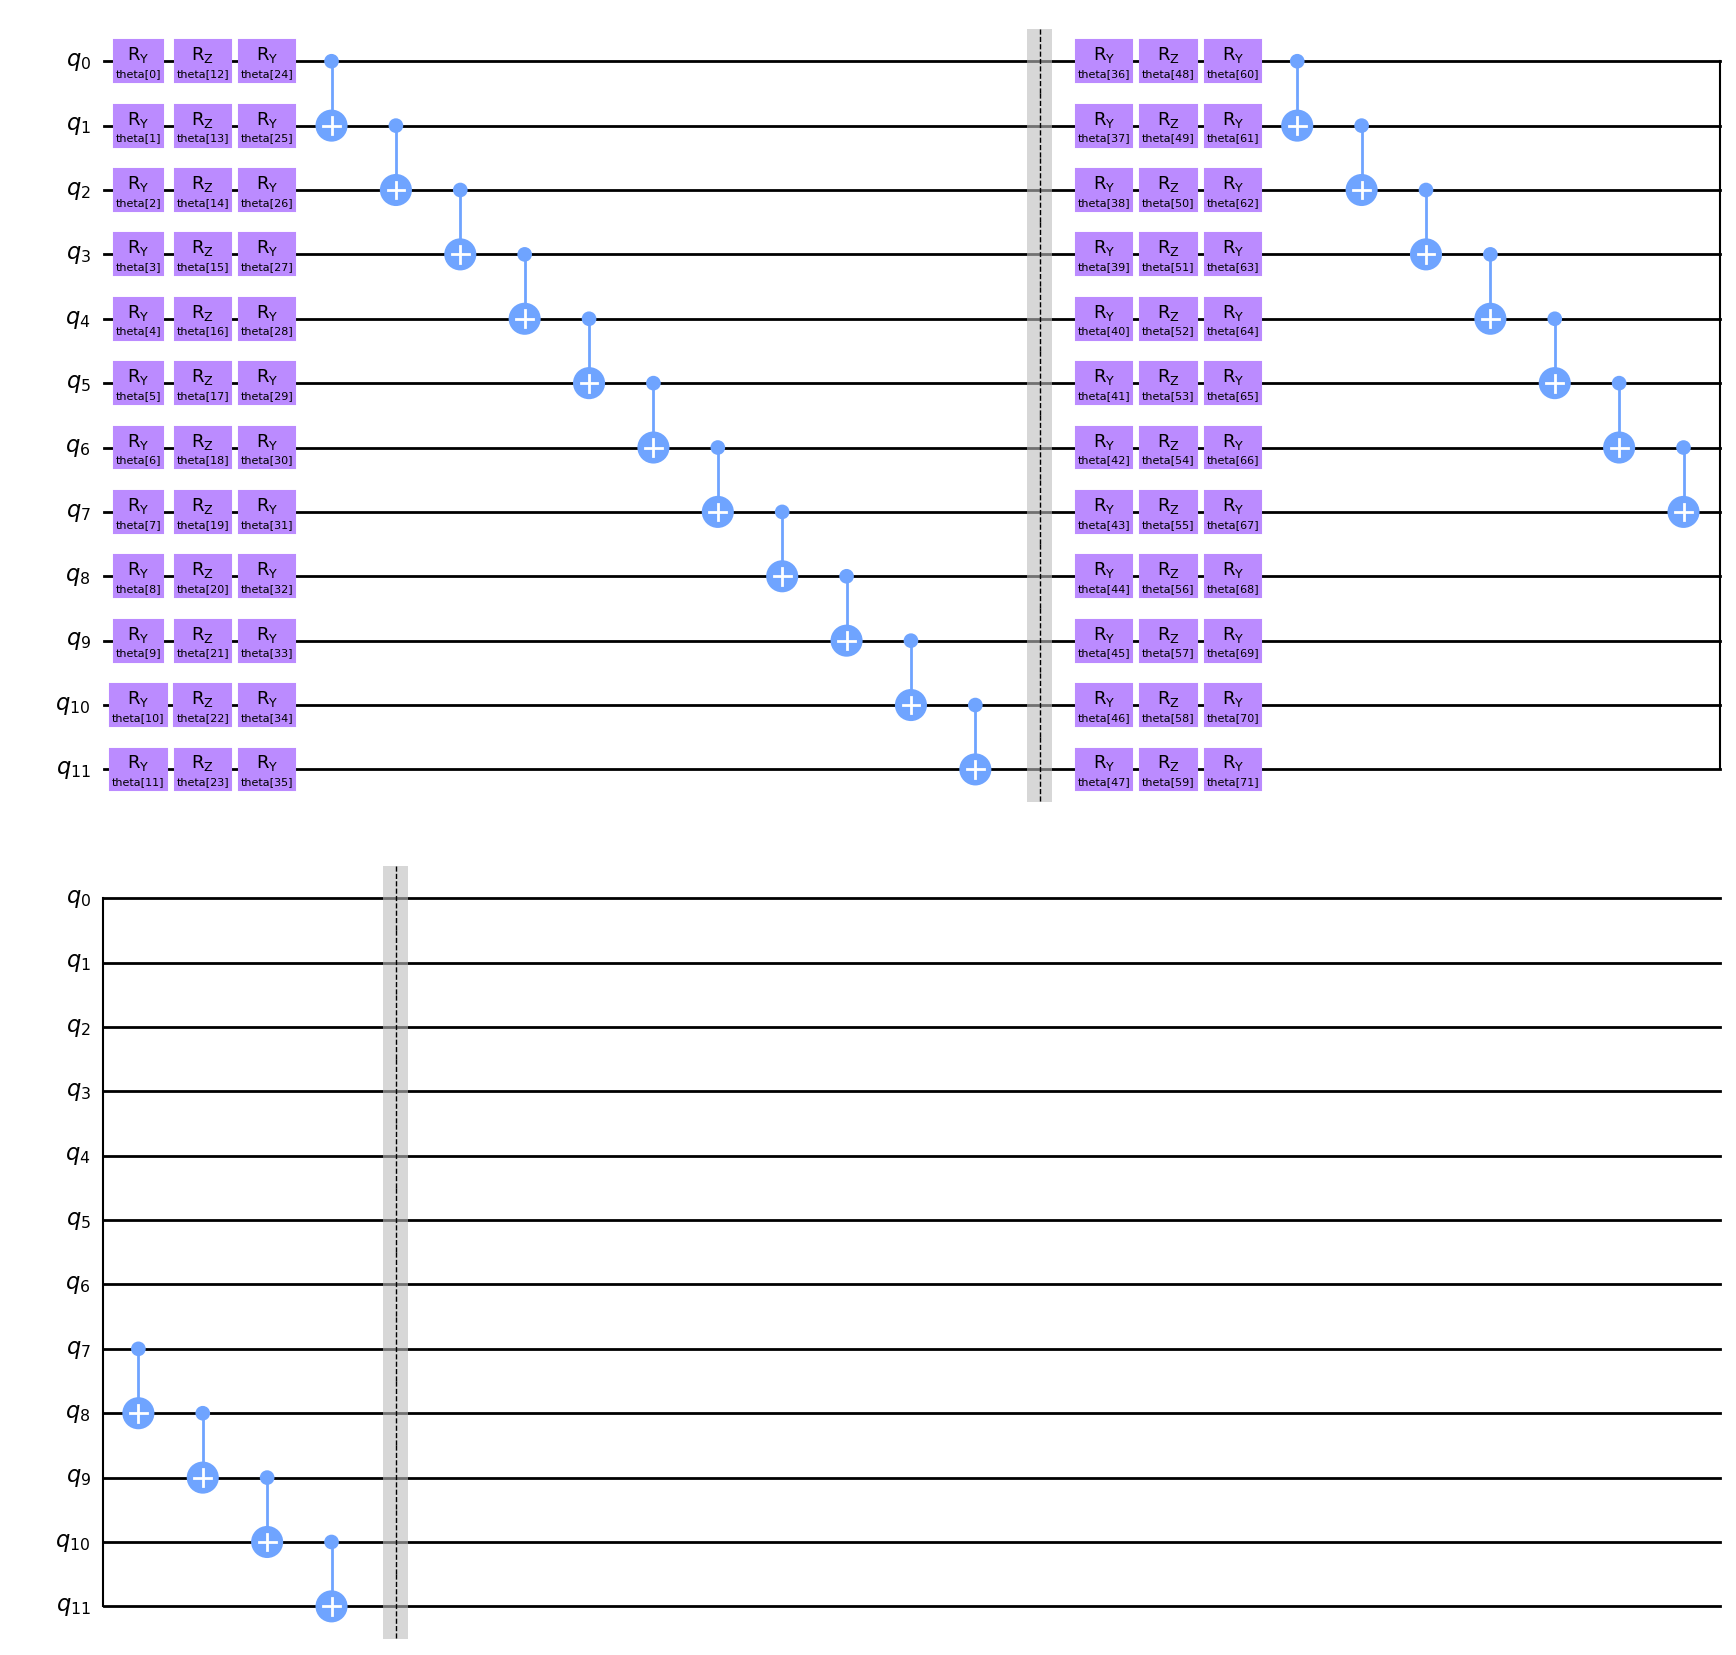

In [4]:
n_qubits=12
n=3
theta = qiskit.circuit.ParameterVector('theta',2*n*n_qubits)
#theta = np.random.rand(n*n_qubits)
#print(theta)
qc = qiskit.QuantumCircuit(n_qubits)
for i in range(n_qubits):
    qc.ry(theta[i], i)
for i in range(n_qubits):
    qc.rz(theta[i+n_qubits], i)
for i in range(n_qubits):
    qc.ry(theta[i+2*n_qubits], i)

for i in range(n_qubits-1):
    qc.cnot(i, i+1)
qc.barrier()

for i in range(n_qubits):
    qc.ry(theta[i+3*n_qubits], i)
for i in range(n_qubits):
    qc.rz(theta[i+4*n_qubits], i)
for i in range(n_qubits):
    qc.ry(theta[i+5*n_qubits], i)

for i in range(n_qubits-1):
    qc.cnot(i, i+1)
qc.barrier()

qc.draw('mpl')

In [5]:
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.primitives import Estimator
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper, QubitConverter, ParityMapper
from qiskit_nature.units import DistanceUnit
from qiskit.utils import algorithm_globals

optimizer = SLSQP(maxiter=60)
estimator = Estimator()
#algorithm_globals.random_seed = 50

driver = PySCFDriver(
        atom="Li 0 0 0; H 0 0 1.5",
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )
problem = driver.run()
hamiltonian = problem.hamiltonian.second_q_op()
algorithm_globals.random_seed = 50

mapper=JordanWignerMapper()
qubit_converter = QubitConverter(mapper)
qubit_op = qubit_converter.convert(hamiltonian)
vqe = VQE(estimator = estimator, ansatz = qc, optimizer=optimizer)
ene_vqe = vqe.compute_minimum_eigenvalue(qubit_op).eigenvalue.real
print(ene_vqe)

overwrite output file: /tmp/tmp5am7tcu6.log


/tmp/ipykernel_2751/2065350702.py:27: DeprecationWarning: The QubitConverter class is deprecated as of version 0.6.0 and will be removed no sooner than 3 months after the release . Instead you should directly use the QubitMapper instance which you used to pass into the QubitConverter as the first argument. Refer to the documentation of the qiskit_nature.second_q.mappers module for more information.
  qubit_converter = QubitConverter(mapper)
/home/ltnhan/.local/lib/python3.8/site-packages/qiskit_nature/deprecation.py:297: PauliSumOpDeprecationWarning: PauliSumOp is deprecated as of version 0.6.0 and support for them will be removed no sooner than 3 months after the release. Instead, use SparsePauliOp. You can switch to SparsePauliOp immediately, by setting `qiskit_nature.settings.use_pauli_sum_op` to `False`.
  return func(*args, **kwargs)


-8.921706641232387


In [6]:

optimizers = [L_BFGS_B(maxiter=60), SLSQP(maxiter=60)]
converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

def vqe_convergence(qc):
    for i, optimizer in enumerate(optimizers):
        print('\rOptimizer: {}        '.format(type(optimizer).__name__), end='')
        algorithm_globals.random_seed = 50
        ansatz = qc

        counts = []
        values = []
        def store_intermediate_result(eval_count, parameters, mean, std):
            counts.append(eval_count)
            values.append(mean)

        vqe = VQE(estimator = estimator, ansatz = qc, optimizer=optimizer, callback=store_intermediate_result)
        #vqe = VQE(ansatz, optimizer, callback=store_intermediate_result,
        #          quantum_instance=QuantumInstance(backend=Aer.get_backend('statevector_simulator')))
        result = vqe.compute_minimum_eigenvalue(qubit_op)
        print(result.eigenvalue)
        converge_cnts[i] = np.asarray(counts)
        converge_vals[i] = np.asarray(values)
    return converge_cnts, converge_vals

In [ ]:
import pylab

converge_cnts, converge_vals = vqe_convergence(qc)
pylab.rcParams['figure.figsize'] = (8, 5)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_cnts[i], converge_vals[i], label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence for various optimizers')
pylab.legend(loc='upper right');

In [7]:
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.primitives import Estimator
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper, QubitConverter, ParityMapper
from qiskit_nature.units import DistanceUnit
from qiskit.utils import algorithm_globals


def VQE_fitness(qc: qiskit.QuantumCircuit):

    driver = PySCFDriver(
        atom="Li 0 0 0; H 0 0 1.5",
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )
    problem = driver.run()
    hamiltonian = problem.hamiltonian.second_q_op()

    optimizer = SLSQP(maxiter=40)
    estimator = Estimator()
    algorithm_globals.random_seed = 50
    
    mapper=JordanWignerMapper()
    qubit_converter = QubitConverter(mapper)
    qubit_op = qubit_converter.convert(hamiltonian)
    vqe = VQE(estimator = estimator, ansatz = qc, optimizer=optimizer)
    ene = vqe.compute_minimum_eigenvalue(qubit_op).eigenvalue
    print(ene)
    return ene
ene_vqe = -8.9217
print(ene_vqe)
def thres(GA_eigenvalue):
    if abs(GA_eigenvalue - ene_vqe) < 0.01:
        return True
    return False


-8.9217


Main algorithm, includes: init population, selection, crossover, mutate.

In [8]:
params = {'depth': 4,
          'num_circuit': 8,  # Must mod 8 = 0
          'num_generation': 10,
          'num_qubits': 12,
          'threshold': thres,
          'prob_mutate': 0.01}

env = environment.EEnvironment(
    params,
    fitness_func = VQE_fitness,
    selection_func = selection.elitist_selection,
    crossover_func= crossover.onepoint_crossover,
    mutate_func=mutate.bitflip_mutate,
    pool = qtm.constant.operations
)

#env.initialize_population()
env.evol() 

Step:   0%|          | 0/10 [00:00<?, ?it/s]

Initialize population ...
overwrite output file: /tmp/tmppxyviz0k.log
-8.749920051393472
overwrite output file: /tmp/tmptwcpc5n3.log
-8.749919618167509
overwrite output file: /tmp/tmphvmd6ilc.log
-8.486767944373694
overwrite output file: /tmp/tmpgldbzzwy.log
-8.486755091735834
overwrite output file: /tmp/tmpg3nf1vq6.log
-8.536794260907094
overwrite output file: /tmp/tmpz5hmmw5e.log
-8.536794253727232
overwrite output file: /tmp/tmpcrr3mxp8.log
-8.43968146988194
overwrite output file: /tmp/tmp7hvw3xyd.log
-8.439683497811156
overwrite output file: /tmp/tmp1hxuj2au.log
-6.53512473915878
overwrite output file: /tmp/tmp5loqkvah.log
-6.535489167390393
overwrite output file: /tmp/tmptf63r_fe.log
-8.16776652914229
overwrite output file: /tmp/tmpxlor7gia.log
-8.167766526691425
overwrite output file: /tmp/tmpxqff7whv.log
-8.80931941789792
overwrite output file: /tmp/tmpk6ems5be.log
-8.809319418645023
overwrite output file: /tmp/tmpxvnsk593.log
-7.411958316782199
overwrite output file: /tmp/tmpcd

Step:  10%|█         | 1/10 [14:27<2:10:06, 867.44s/it]

-7.297142330122056
End evol progress, best score ever: -8.921711466479202


Test best candidate again

In [ ]:
qc = env.best_candidate.qc
#env.plot()
print(VQE_fitness(qc))

In [ ]:
qc.draw('mpl')

In [11]:
optimizers = [L_BFGS_B(maxiter=50), SLSQP(maxiter=50)]

converge_cnts, converge_vals = vqe_convergence(qc)
pylab.rcParams['figure.figsize'] = (8, 5)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_cnts[i], converge_vals[i], label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence for various optimizers')
pylab.legend(loc='upper right');

Optimizer: L_BFGS_B        